# Imports and data loading

**Experiment**: <br>
1. Inputs : Min, max, Qty, modal_price from time t-0 to t-5
2. Output : Min, max, Qty, modal_price from time t+1 to t+5
3. Models : 
  1. Encoder-Decoder LSTM.
  2. Encoder-Decoder Bi-Dir LSTM.

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

In [2]:
from keras.losses import mean_absolute_percentage_error 

In [3]:
from keras.layers import RepeatVector

In [4]:
from google. colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [5]:
df_tomato = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Tomato_Kolar_2020_23.xlsx')
df_tomato.shape

(1163, 10)

In [6]:
df_tomato.head(5)

,state,district,market,commodity,variety,arrival_date,min_price,max_price,modal_price,quantity
0,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-01,400,1330,730,6224
1,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-02,400,1670,930,4439
2,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-03,400,1670,930,5983
3,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-04,330,1330,800,7830
4,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-05,330,1200,530,6310


# EDA

In [7]:
df_tomato_2 = df_tomato.set_index('arrival_date',drop=True, verify_integrity=True)

In [8]:
df_tomato_2.sort_index(axis=1)

,commodity,district,market,max_price,min_price,modal_price,quantity,state,variety
arrival_date,,,,,,,,,
2023-01-01,Tomato,Kolar,Kolar,1330,400,730,6224,Karnataka,Tomato
2023-01-02,Tomato,Kolar,Kolar,1670,400,930,4439,Karnataka,Tomato
2023-01-03,Tomato,Kolar,Kolar,1670,400,930,5983,Karnataka,Tomato
2023-01-04,Tomato,Kolar,Kolar,1330,330,800,7830,Karnataka,Tomato
2023-01-05,Tomato,Kolar,Kolar,1200,330,530,6310,Karnataka,Tomato
...,...,...,...,...,...,...,...,...,...
2020-12-26,Tomato,Kolar,Kolar,1667,333,933,12250,Karnataka,Tomato
2020-12-27,Tomato,Kolar,Kolar,2000,667,1200,8530,Karnataka,Tomato
2020-12-28,Tomato,Kolar,Kolar,1733,400,1000,10794,Karnataka,Tomato


In [9]:
df_tomato_2 = df_tomato_2.drop(['state','district', 'market', 'commodity', 'variety'], axis=1)
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [10]:
df_tomato_2.isnull().sum()

min_price      0
max_price      0
modal_price    0
quantity       0
dtype: int64

In [11]:
cor_matrix = df_tomato_2.corr()

Text(0.5, 1.0, 'Heat map of correlation between features')

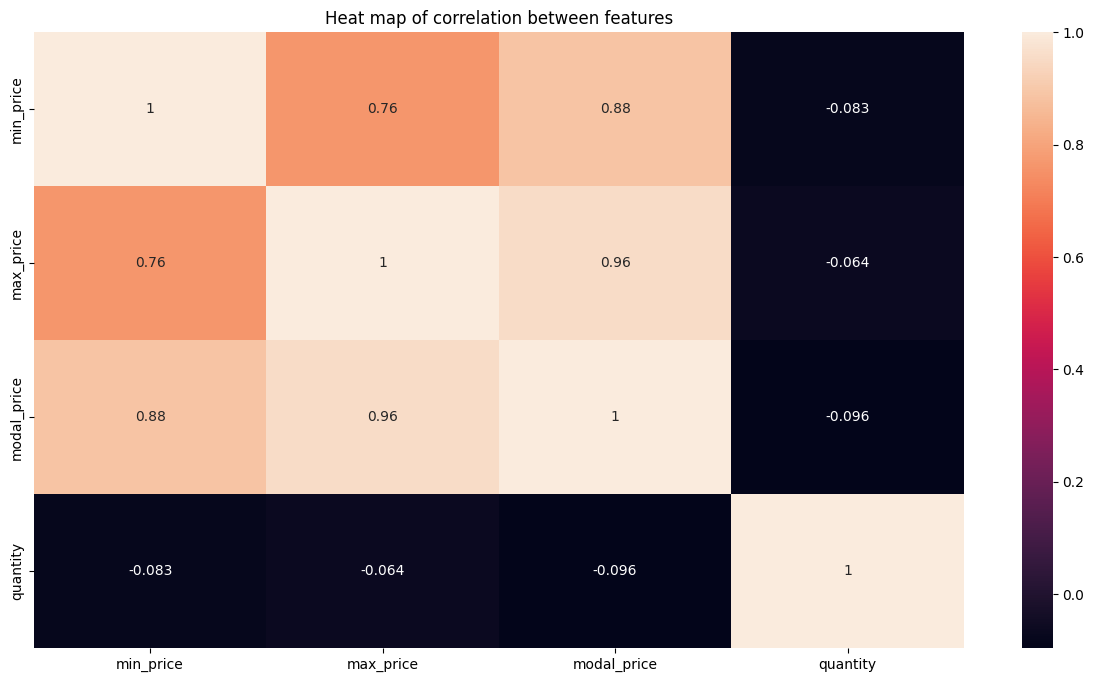

In [12]:
sns.heatmap(cor_matrix,annot=True)
plt.title("Heat map of correlation between features")

In [13]:
# Drop min_price and max_price because of hig auto-correlation 
# df_tomato_3 = df_tomato_2.drop(['min_price','max_price'], axis=1)
# df_tomato_3.head()

In [14]:
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [15]:
# Creating a new dataset and Sorting in ascending order of time series
df_tomato_3 = df_tomato_2[['quantity','min_price','max_price','modal_price']]
df_tomato_3.sort_index(ascending=True,inplace=True)
df_tomato_3.head()

,quantity,min_price,max_price,modal_price
arrival_date,,,,
2020-01-01,4144,333,1467,733
2020-01-02,4430,333,1733,986
2020-01-03,4532,400,2000,1047
2020-01-04,5578,333,2000,1033
2020-01-05,4960,333,2000,1033


# Preparing the dataset for training

### Creating Feature variable

In [19]:
# Function to create as many as features to represent the window size
def createWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(0,winSize):
    df_temp["quantity_t"+str(i+1)] = df_tomato_3['quantity'].shift(i)
    df_temp["min_price_t"+str(i+1)] = df_tomato_3['min_price'].shift(i)
    df_temp["max_price_t"+str(i+1)] = df_tomato_3['max_price'].shift(i)
    df_temp["modal_price_t"+str(i+1)] = df_tomato_3['modal_price'].shift(i)
  return df_temp

In [20]:
# Generating new features
df_newFeatures = createWindow(5)
df_newFeatures.head()

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,max_price_t3,modal_price_t3,quantity_t4,min_price_t4,max_price_t4,modal_price_t4,quantity_t5,min_price_t5,max_price_t5,modal_price_t5
arrival_date,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,4430,333,1733,986,4144.0,333.0,1467.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,4532,400,2000,1047,4430.0,333.0,1733.0,986.0,4144.0,333.0,1467.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,5578,333,2000,1033,4532.0,400.0,2000.0,1047.0,4430.0,333.0,1733.0,986.0,4144.0,333.0,1467.0,733.0,NaN,NaN,NaN,NaN
2020-01-05,4960,333,2000,1033,5578.0,333.0,2000.0,1033.0,4532.0,400.0,2000.0,1047.0,4430.0,333.0,1733.0,986.0,4144.0,333.0,1467.0,733.0


In [21]:
# joining with base dataframe
df_tomato_4 = df_newFeatures.copy()
df_tomato_4.head()

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,max_price_t3,modal_price_t3,quantity_t4,min_price_t4,max_price_t4,modal_price_t4,quantity_t5,min_price_t5,max_price_t5,modal_price_t5
arrival_date,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,4430,333,1733,986,4144.0,333.0,1467.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,4532,400,2000,1047,4430.0,333.0,1733.0,986.0,4144.0,333.0,1467.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,5578,333,2000,1033,4532.0,400.0,2000.0,1047.0,4430.0,333.0,1733.0,986.0,4144.0,333.0,1467.0,733.0,NaN,NaN,NaN,NaN
2020-01-05,4960,333,2000,1033,5578.0,333.0,2000.0,1033.0,4532.0,400.0,2000.0,1047.0,4430.0,333.0,1733.0,986.0,4144.0,333.0,1467.0,733.0


In [22]:
# Replacing null values with 0, thus created window of 30 days as each input.
for val in df_tomato_4.columns:
  df_tomato_4[val].fillna(0, inplace=True)
df_tomato_4.head()

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,max_price_t3,modal_price_t3,quantity_t4,min_price_t4,max_price_t4,modal_price_t4,quantity_t5,min_price_t5,max_price_t5,modal_price_t5
arrival_date,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,4430,333,1733,986,4144.0,333.0,1467.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,4532,400,2000,1047,4430.0,333.0,1733.0,986.0,4144.0,333.0,1467.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,5578,333,2000,1033,4532.0,400.0,2000.0,1047.0,4430.0,333.0,1733.0,986.0,4144.0,333.0,1467.0,733.0,0.0,0.0,0.0,0.0
2020-01-05,4960,333,2000,1033,5578.0,333.0,2000.0,1033.0,4532.0,400.0,2000.0,1047.0,4430.0,333.0,1733.0,986.0,4144.0,333.0,1467.0,733.0


In [ ]:
# joining with base dataframe
#df_tomato_4 = df_tomato_3.join(df_newCols)
#df_tomato_4.head()

### Creating Target Variable

In [23]:
# Function to create as many as features to represent the window size
def createTargetWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["target_quantity_t"+str(i)] = df_tomato_3['quantity'].shift(-i)
    df_temp["target_min_price_t"+str(i)] = df_tomato_3['min_price'].shift(-i)
    df_temp["target_max_price_t"+str(i)] = df_tomato_3['max_price'].shift(-i)
    df_temp["target_modal_price_t"+str(i)] = df_tomato_3['modal_price'].shift(-i)
  return df_temp

In [24]:
# Generating target columns
df_newTargetCols = createTargetWindow(5)
df_newTargetCols.head()

,target_quantity_t1,target_min_price_t1,target_max_price_t1,target_modal_price_t1,target_quantity_t2,target_min_price_t2,target_max_price_t2,target_modal_price_t2,target_quantity_t3,target_min_price_t3,target_max_price_t3,target_modal_price_t3,target_quantity_t4,target_min_price_t4,target_max_price_t4,target_modal_price_t4,target_quantity_t5,target_min_price_t5,target_max_price_t5,target_modal_price_t5
arrival_date,,,,,,,,,,,,,,,,,,,,
2020-01-01,4430.0,333.0,1733.0,986.0,4532.0,400.0,2000.0,1047.0,5578.0,333.0,2000.0,1033.0,4960.0,333.0,2000.0,1033.0,5369.0,400.0,2000.0,1046.0
2020-01-02,4532.0,400.0,2000.0,1047.0,5578.0,333.0,2000.0,1033.0,4960.0,333.0,2000.0,1033.0,5369.0,400.0,2000.0,1046.0,5243.0,333.0,2000.0,1153.0
2020-01-03,5578.0,333.0,2000.0,1033.0,4960.0,333.0,2000.0,1033.0,5369.0,400.0,2000.0,1046.0,5243.0,333.0,2000.0,1153.0,4927.0,333.0,1800.0,933.0
2020-01-04,4960.0,333.0,2000.0,1033.0,5369.0,400.0,2000.0,1046.0,5243.0,333.0,2000.0,1153.0,4927.0,333.0,1800.0,933.0,4898.0,333.0,2000.0,1133.0
2020-01-05,5369.0,400.0,2000.0,1046.0,5243.0,333.0,2000.0,1153.0,4927.0,333.0,1800.0,933.0,4898.0,333.0,2000.0,1133.0,5112.0,333.0,1733.0,933.0


In [25]:
# joining with base dataframe
df_tomato_4 = df_tomato_4.join(df_newTargetCols)
df_tomato_4.head()

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,...,target_max_price_t3,target_modal_price_t3,target_quantity_t4,target_min_price_t4,target_max_price_t4,target_modal_price_t4,target_quantity_t5,target_min_price_t5,target_max_price_t5,target_modal_price_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,0.0,0.0,0.0,0.0,0.0,0.0,...,2000.0,1033.0,4960.0,333.0,2000.0,1033.0,5369.0,400.0,2000.0,1046.0
2020-01-02,4430,333,1733,986,4144.0,333.0,1467.0,733.0,0.0,0.0,...,2000.0,1033.0,5369.0,400.0,2000.0,1046.0,5243.0,333.0,2000.0,1153.0
2020-01-03,4532,400,2000,1047,4430.0,333.0,1733.0,986.0,4144.0,333.0,...,2000.0,1046.0,5243.0,333.0,2000.0,1153.0,4927.0,333.0,1800.0,933.0
2020-01-04,5578,333,2000,1033,4532.0,400.0,2000.0,1047.0,4430.0,333.0,...,2000.0,1153.0,4927.0,333.0,1800.0,933.0,4898.0,333.0,2000.0,1133.0
2020-01-05,4960,333,2000,1033,5578.0,333.0,2000.0,1033.0,4532.0,400.0,...,1800.0,933.0,4898.0,333.0,2000.0,1133.0,5112.0,333.0,1733.0,933.0


In [26]:
# Drop all the null values
df_tomato_4.dropna(inplace=True)
df_tomato_4

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,...,target_max_price_t3,target_modal_price_t3,target_quantity_t4,target_min_price_t4,target_max_price_t4,target_modal_price_t4,target_quantity_t5,target_min_price_t5,target_max_price_t5,target_modal_price_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,0.0,0.0,0.0,0.0,0.0,0.0,...,2000.0,1033.0,4960.0,333.0,2000.0,1033.0,5369.0,400.0,2000.0,1046.0
2020-01-02,4430,333,1733,986,4144.0,333.0,1467.0,733.0,0.0,0.0,...,2000.0,1033.0,5369.0,400.0,2000.0,1046.0,5243.0,333.0,2000.0,1153.0
2020-01-03,4532,400,2000,1047,4430.0,333.0,1733.0,986.0,4144.0,333.0,...,2000.0,1046.0,5243.0,333.0,2000.0,1153.0,4927.0,333.0,1800.0,933.0
2020-01-04,5578,333,2000,1033,4532.0,400.0,2000.0,1047.0,4430.0,333.0,...,2000.0,1153.0,4927.0,333.0,1800.0,933.0,4898.0,333.0,2000.0,1133.0
2020-01-05,4960,333,2000,1033,5578.0,333.0,2000.0,1033.0,4532.0,400.0,...,1800.0,933.0,4898.0,333.0,2000.0,1133.0,5112.0,333.0,1733.0,933.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,2874,400,1800,1000,3424.0,400.0,2000.0,1200.0,3725.0,400.0,...,1670.0,1000.0,3678.0,330.0,1430.0,930.0,4464.0,330.0,1330.0,870.0
2023-03-10,3506,530,2000,1270,2874.0,400.0,1800.0,1000.0,3424.0,400.0,...,1430.0,930.0,4464.0,330.0,1330.0,870.0,3434.0,330.0,1330.0,930.0
2023-03-11,3698,400,1870,1200,3506.0,530.0,2000.0,1270.0,2874.0,400.0,...,1330.0,870.0,3434.0,330.0,1330.0,930.0,3961.0,330.0,1200.0,730.0


### Scaling

In [27]:
# Preprocessing the dataset
# Extract the values from the DataFrame
data_to_scale = df_tomato_4.copy()
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler to the data
scaler.fit(data_to_scale)
# Transform the data
scaled_data = scaler.transform(data_to_scale)
# convert the scaled_data array back to a DataFrame with Timestamp index
scaled_data_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns, index=data_to_scale.index)
# combine the scaled data with the Timestamp index column
# scaled_data_df = pd.concat([df_tomato_3.index.to_frame(), scaled_data_df], axis=1)
scaled_data_df.head()

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,...,target_max_price_t3,target_modal_price_t3,target_quantity_t4,target_min_price_t4,target_max_price_t4,target_modal_price_t4,target_quantity_t5,target_min_price_t5,target_max_price_t5,target_modal_price_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.076304,0.068107,0.129021,0.091897,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.193470,0.143621,0.096191,0.068107,0.193470,0.143621,0.106158,0.085133,0.193470,0.145862
2020-01-02,0.083274,0.068107,0.161185,0.135517,0.098559,0.08325,0.169204,0.122167,0.000000,0.00000,...,0.193470,0.143621,0.106158,0.085133,0.193470,0.145862,0.103088,0.068107,0.193470,0.164310
2020-01-03,0.085760,0.085133,0.193470,0.146034,0.105361,0.08325,0.199885,0.164333,0.098559,0.08325,...,0.193470,0.145862,0.103088,0.068107,0.193470,0.164310,0.095387,0.068107,0.169287,0.126379
2020-01-04,0.111252,0.068107,0.193470,0.143621,0.107787,0.10000,0.230681,0.174500,0.105361,0.08325,...,0.193470,0.164310,0.095387,0.068107,0.169287,0.126379,0.094680,0.068107,0.193470,0.160862
2020-01-05,0.096191,0.068107,0.193470,0.143621,0.132664,0.08325,0.230681,0.172167,0.107787,0.10000,...,0.169287,0.126379,0.094680,0.068107,0.193470,0.160862,0.099895,0.068107,0.161185,0.126379


### Train Test Split

In [28]:
# Split the data into train and test sets
train_size = int(len(scaled_data_df) * 0.8)
train_data = scaled_data_df[:train_size]
test_data = scaled_data_df[train_size:]

In [29]:
# Creating Training dataset
train_X = pd.DataFrame(index=train_data.index)
train_y = pd.DataFrame(index=train_data.index)
for i in train_data.columns:
  if i.startswith('target'):
    train_y[i] = train_data[i]
  else:
    train_X[i] = train_data[i]

In [30]:
# Creating Testing dataset
test_X = pd.DataFrame(index=test_data.index)
test_y = pd.DataFrame(index=test_data.index)
for i in test_data.columns:
  if i.startswith('target'):
    test_y[i] = test_data[i]
  else:
    test_X[i] = test_data[i]

In [31]:
# Splitting target and feature variables
#train_X = train_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#train_y = train_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

#test_X = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#test_y = test_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

In [32]:
# Converting Dataframe to 3D array
vec_train_X = train_X.values
vec_train_y = train_y.values

vec_test_X = test_X.values
vec_test_y = test_y.values

In [33]:
# reshape input to be 3D [samples, look_back, features]
# samples -> are the number of rows in your data set
# look_back -> number of times to feed in the model or LSTM
# features -> number of columns of each sample

vec_train_X = vec_train_X.reshape((train_X.shape[0], 5, 4))
vec_train_y = vec_train_y.reshape((train_y.shape[0], 5, 4))

vec_test_X = vec_test_X.reshape((test_X.shape[0], 5, 4))
vec_test_y  = vec_test_y.reshape((test_y.shape[0], 5, 4))

In [34]:
# Verifying the shape of train and test
print(vec_train_X.shape, vec_train_y.shape, vec_test_X.shape, vec_test_y.shape)

(926, 5, 4) (926, 5, 4) (232, 5, 4) (232, 5, 4)


In [35]:
vec_train_X[10,:,:]

array([[0.09884727, 0.06810673, 0.19347037, 0.16431034],
       [0.12158113, 0.08325   , 0.19988466, 0.1555    ],
       [0.11649146, 0.08325   , 0.23068051, 0.18883333],
       [0.11718118, 0.08325   , 0.20761246, 0.1555    ],
       [0.12469676, 0.08325   , 0.23068051, 0.19216667]])

# Model 1 - Encoder - Decoder model using LSTM

## Model building

In [36]:
# Build the Encoder - Decoder using LSTM model
# define model
model_encDec_1 = Sequential()
model_encDec_1.add(LSTM(128, activation='relu', 
                        input_shape=(vec_train_X.shape[1], vec_train_X.shape[2]), 
                        return_sequences=True))
model_encDec_1.add(LSTM(64, activation='relu', return_sequences=False))
model_encDec_1.add(RepeatVector(vec_train_y.shape[1]))
model_encDec_1.add(LSTM(64, activation='relu', return_sequences=True))
model_encDec_1.add(LSTM(128, activation='relu', return_sequences=True))
model_encDec_1.add(TimeDistributed(Dense(vec_train_X.shape[2])))
model_encDec_1.compile(optimizer='adam', loss='mae')
model_encDec_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            68096     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 5, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 5, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 5, 128)            98816     
                                                                 
 time_distributed (TimeDistr  (None, 5, 4)             516       
 ibuted)                                                

In [37]:
# fit network
history = model_encDec_1.fit(vec_train_X, vec_train_y, epochs=50, batch_size=100, 
                             validation_data=(vec_test_X, vec_test_y), verbose=2,
                             shuffle=False)

Epoch 1/50
10/10 - 8s - loss: 0.1880 - val_loss: 0.1319 - 8s/epoch - 829ms/step
Epoch 2/50
10/10 - 1s - loss: 0.1500 - val_loss: 0.0884 - 552ms/epoch - 55ms/step
Epoch 3/50
10/10 - 1s - loss: 0.1281 - val_loss: 0.0882 - 510ms/epoch - 51ms/step
Epoch 4/50
10/10 - 1s - loss: 0.1241 - val_loss: 0.0825 - 511ms/epoch - 51ms/step
Epoch 5/50
10/10 - 1s - loss: 0.1196 - val_loss: 0.0806 - 547ms/epoch - 55ms/step
Epoch 6/50
10/10 - 1s - loss: 0.1151 - val_loss: 0.0774 - 630ms/epoch - 63ms/step
Epoch 7/50
10/10 - 1s - loss: 0.1112 - val_loss: 0.0749 - 618ms/epoch - 62ms/step
Epoch 8/50
10/10 - 1s - loss: 0.1060 - val_loss: 0.0731 - 597ms/epoch - 60ms/step
Epoch 9/50
10/10 - 1s - loss: 0.1011 - val_loss: 0.0696 - 563ms/epoch - 56ms/step
Epoch 10/50
10/10 - 1s - loss: 0.0908 - val_loss: 0.0693 - 561ms/epoch - 56ms/step
Epoch 11/50
10/10 - 1s - loss: 0.0883 - val_loss: 0.0646 - 934ms/epoch - 93ms/step
Epoch 12/50
10/10 - 1s - loss: 0.0830 - val_loss: 0.0597 - 1s/epoch - 108ms/step
Epoch 13/50
10/10

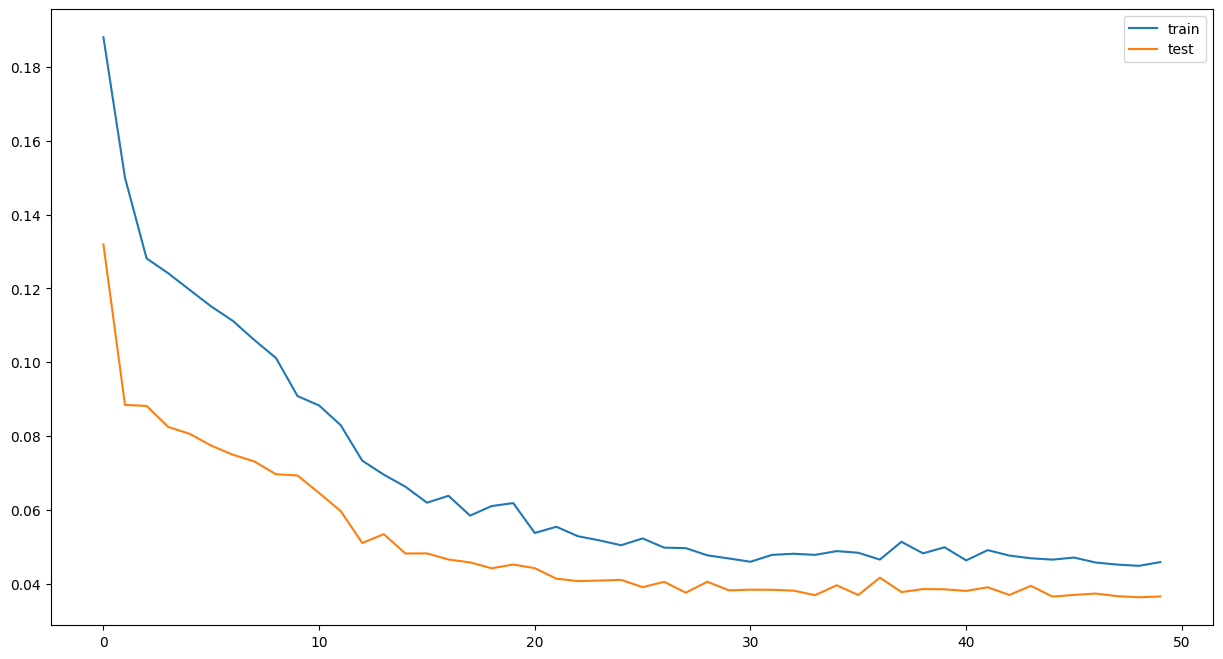

In [38]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [39]:
# make a prediction
pred_y = model_encDec_1.predict(vec_test_X)

8/8 [==============================] - 1s 11ms/step


In [40]:
pred_y[:5]

array([[[0.831351  , 0.05374028, 0.0970238 , 0.0683116 ],
        [0.843447  , 0.04841153, 0.09396008, 0.06430182],
        [0.8613498 , 0.05001437, 0.10460368, 0.06352726],
        [0.85581654, 0.05045029, 0.11042303, 0.06637356],
        [0.85174084, 0.05037051, 0.11609903, 0.06939316]],

       [[0.8194667 , 0.05268336, 0.09657127, 0.06773932],
        [0.8411352 , 0.04667079, 0.09302069, 0.06284893],
        [0.860033  , 0.0483959 , 0.10355724, 0.0619916 ],
        [0.85510033, 0.04887084, 0.10938016, 0.06456041],
        [0.85094553, 0.04890218, 0.11492999, 0.06743159]],

       [[0.7848419 , 0.05217137, 0.0991154 , 0.06901002],
        [0.8257091 , 0.04506015, 0.09472302, 0.06240693],
        [0.84701234, 0.0470951 , 0.10459885, 0.06145036],
        [0.8439762 , 0.04799221, 0.11018525, 0.06376797],
        [0.8402123 , 0.04827111, 0.11533743, 0.06647626]],

       [[0.7947008 , 0.05313047, 0.09982662, 0.06967277],
        [0.8277468 , 0.04658752, 0.09573469, 0.06374405],
        

In [41]:
pred_y.shape

(232, 5, 4)

## Resacling Prediction

In [42]:
test_data

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,...,target_max_price_t3,target_modal_price_t3,target_quantity_t4,target_min_price_t4,target_max_price_t4,target_modal_price_t4,target_quantity_t5,target_min_price_t5,target_max_price_t5,target_modal_price_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.875826,0.0825,0.115340,0.111667,0.841792,0.1175,...,0.105200,0.091379,0.798577,0.059720,0.096735,0.091379,0.731411,0.059720,0.072551,0.046552
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.878514,0.0825,0.115340,0.111667,0.875826,0.0825,...,0.096735,0.091379,0.731411,0.059720,0.072551,0.046552,0.620647,0.059720,0.081016,0.056897
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.867811,0.0825,0.123414,0.121667,0.878514,0.0825,...,0.072551,0.046552,0.620647,0.059720,0.081016,0.056897,0.741744,0.067344,0.112455,0.068966
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.809613,0.0825,0.146482,0.111667,0.867811,0.0825,...,0.081016,0.056897,0.741744,0.067344,0.112455,0.068966,0.733288,0.067344,0.112455,0.081034
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.857989,0.0825,0.146482,0.121667,0.809613,0.0825,...,0.112455,0.068966,0.733288,0.067344,0.112455,0.081034,0.707894,0.067344,0.112455,0.081034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.081435,0.1000,0.230681,0.200000,0.088593,0.1000,...,0.153567,0.137931,0.064948,0.067344,0.124547,0.125862,0.084103,0.067344,0.112455,0.115517
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.068354,0.1000,0.207612,0.166667,0.081435,0.1000,...,0.124547,0.125862,0.084103,0.067344,0.112455,0.115517,0.059001,0.067344,0.112455,0.125862
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.083385,0.1325,0.230681,0.211667,0.068354,0.1000,...,0.112455,0.115517,0.059001,0.067344,0.112455,0.125862,0.071845,0.067344,0.096735,0.091379


In [43]:
data_pred = test_data.copy()

In [44]:
for i in data_pred.columns:
  if i.startswith('target'):
    data_pred.drop(columns=i,inplace=True)

In [45]:
# Creating Testing dataset
temp_pred_df = pd.DataFrame(data=pred_y.reshape(test_data.shape[0],20),
                            index=test_data.index,
                            columns=['pred_qty_t1',	'pred_min_t1',	'pred_max_t1',	'pred_mode_t1',
                                      'pred_qty_t2',	'pred_min_t2',	'pred_max_t2',	'pred_mode_t2',
                                      'pred_qty_t3',	'pred_min_t3',	'pred_max_t3',	'pred_mode_t3',
                                      'pred_qty_t4',	'pred_min_t4',	'pred_max_t4',	'pred_mode_t4',
                                      'pred_qty_t5',	'pred_min_t5',	'pred_max_t5',	'pred_mode_t5'])

In [46]:
data_pred = data_pred.join(temp_pred_df)
data_pred

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,...,pred_max_t3,pred_mode_t3,pred_qty_t4,pred_min_t4,pred_max_t4,pred_mode_t4,pred_qty_t5,pred_min_t5,pred_max_t5,pred_mode_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.875826,0.0825,0.115340,0.111667,0.841792,0.1175,...,0.104604,0.063527,0.855817,0.050450,0.110423,0.066374,0.851741,0.050371,0.116099,0.069393
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.878514,0.0825,0.115340,0.111667,0.875826,0.0825,...,0.103557,0.061992,0.855100,0.048871,0.109380,0.064560,0.850946,0.048902,0.114930,0.067432
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.867811,0.0825,0.123414,0.121667,0.878514,0.0825,...,0.104599,0.061450,0.843976,0.047992,0.110185,0.063768,0.840212,0.048271,0.115337,0.066476
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.809613,0.0825,0.146482,0.111667,0.867811,0.0825,...,0.105685,0.062913,0.844541,0.049142,0.111244,0.065430,0.840824,0.049440,0.116502,0.068309
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.857989,0.0825,0.146482,0.121667,0.809613,0.0825,...,0.107174,0.063104,0.831586,0.048893,0.112541,0.065455,0.828543,0.049411,0.117558,0.068225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.081435,0.1000,0.230681,0.200000,0.088593,0.1000,...,0.168235,0.136902,0.057114,0.092064,0.168170,0.134525,0.052094,0.091847,0.165197,0.130762
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.068354,0.1000,0.207612,0.166667,0.081435,0.1000,...,0.185406,0.149444,0.056815,0.097155,0.185137,0.146975,0.051320,0.097222,0.181599,0.142720
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.083385,0.1325,0.230681,0.211667,0.068354,0.1000,...,0.186529,0.150209,0.057401,0.097328,0.186127,0.147676,0.051859,0.097442,0.182477,0.143329


In [47]:
inv_pred_y = scaler.inverse_transform(data_pred)
inv_pred_y = inv_pred_y[:,-20:]

In [48]:
# Display Predicted values
inv_pred_y[:2,]

array([[35125.82485217,   276.46800814,  1202.38682613,   596.20729089,
        35622.16196519,   255.49936863,  1177.04983324,   572.95054793,
        36356.76720881,   261.8065281 ,  1265.07241696,   568.45812947,
        36129.72021312,   263.52189699,  1313.19844544,   584.96667296,
        35962.48176861,   263.20795948,  1360.13897628,   602.48031616],
       [34638.17751515,   272.30901038,  1198.64437521,   592.88807213,
        35527.3008191 ,   248.64956165,  1169.28112671,   564.52381164,
        36302.73309082,   255.43785939,  1256.41840741,   559.55129266,
        36100.33199233,   257.30676683,  1304.57388848,   574.45035428,
        35929.84802777,   257.43007848,  1350.47100887,   591.10323042]])

## Rescaling Actuals

In [49]:
data_actual= test_data.copy()

In [50]:
inv_test_y = scaler.inverse_transform(data_actual)
inv_test_y = inv_test_y[:,-20:]

In [51]:
# Display Actual target values
inv_test_y[:5,]

array([[36488.,   330.,  1070.,   730., 34041.,   330.,  1270.,   670.,
        36075.,   330.,  1270.,   730., 33781.,   300.,  1200.,   730.,
        31025.,   300.,  1000.,   470.],
       [34041.,   330.,  1270.,   670., 36075.,   330.,  1270.,   730.,
        33781.,   300.,  1200.,   730., 31025.,   300.,  1000.,   470.,
        26480.,   300.,  1070.,   530.],
       [36075.,   330.,  1270.,   730., 33781.,   300.,  1200.,   730.,
        31025.,   300.,  1000.,   470., 26480.,   300.,  1070.,   530.,
        31449.,   330.,  1330.,   600.],
       [33781.,   300.,  1200.,   730., 31025.,   300.,  1000.,   470.,
        26480.,   300.,  1070.,   530., 31449.,   330.,  1330.,   600.,
        31102.,   330.,  1330.,   670.],
       [31025.,   300.,  1000.,   470., 26480.,   300.,  1070.,   530.,
        31449.,   330.,  1330.,   600., 31102.,   330.,  1330.,   670.,
        30060.,   330.,  1330.,   670.]])

## Comapring Actuals vs Predicted

In [52]:
pred_df = pd.DataFrame(index=test_data.index)

In [53]:
k = 1
for i in range(0,20,4):
  pred_df['act_qty_t'+str(k)] = inv_test_y[:,i]
  pred_df['pred_qty_t'+str(k)] = inv_pred_y[:,i]
  i = i+1
  pred_df['act_min_t'+str(k)] = inv_test_y[:,i]
  pred_df['pred_min_t'+str(k)] = inv_pred_y[:,i]
  i = i+1
  pred_df['act_max_t'+str(k)] = inv_test_y[:,i]
  pred_df['pred_max_t'+str(k)] = inv_pred_y[:,i]
  i = i+1
  pred_df['act_mode_t'+str(k)] = inv_test_y[:,i]
  pred_df['pred_mode_t'+str(k)] = inv_pred_y[:,i]
  k=k+1


In [54]:
pred_df

,act_qty_t1,pred_qty_t1,act_min_t1,pred_min_t1,act_max_t1,pred_max_t1,act_mode_t1,pred_mode_t1,act_qty_t2,pred_qty_t2,...,act_mode_t4,pred_mode_t4,act_qty_t5,pred_qty_t5,act_min_t5,pred_min_t5,act_max_t5,pred_max_t5,act_mode_t5,pred_mode_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,36488.0,35125.824852,330.0,276.468008,1070.0,1202.386826,730.0,596.207291,34041.0,35622.161965,...,730.0,584.966673,31025.0,35962.481769,300.0,263.207959,1000.0,1360.138976,470.0,602.480316
2022-07-24,34041.0,34638.177515,330.0,272.309010,1270.0,1198.644375,670.0,592.888072,36075.0,35527.300819,...,470.0,574.450354,26480.0,35929.848028,300.0,257.430078,1070.0,1350.471009,530.0,591.103230
2022-07-25,36075.0,33217.417482,330.0,270.294334,1270.0,1219.684370,730.0,600.258112,33781.0,34894.321687,...,530.0,569.854224,31449.0,35489.430712,330.0,254.946812,1330.0,1353.840558,600.0,585.562283
2022-07-26,33781.0,33621.957983,300.0,274.068386,1200.0,1225.566139,730.0,604.102071,31025.0,34977.934794,...,600.0,579.491453,31102.0,35514.511954,330.0,259.548160,1330.0,1363.472048,670.0,596.193333
2022-07-27,31025.0,32315.718093,300.0,275.176842,1000.0,1251.282196,470.0,614.268534,26480.0,34302.103547,...,670.0,579.636477,30060.0,35010.624788,330.0,259.430741,1330.0,1372.206406,670.0,595.707399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,3506.0,4657.490955,530.0,386.940547,2000.0,1360.377431,1270.0,786.846778,3698.0,4277.395799,...,930.0,980.243018,4464.0,3150.578201,330.0,426.419597,1330.0,1766.182024,870.0,958.421651
2023-03-10,3698.0,4723.560645,400.0,401.530931,1870.0,1450.428054,1200.0,833.105823,2950.0,4325.251017,...,870.0,1052.455062,3434.0,3118.819124,330.0,447.567281,1330.0,1901.824150,930.0,1027.776253
2023-03-11,2950.0,4747.921000,400.0,402.533080,1670.0,1457.558539,1000.0,836.503258,3678.0,4352.611705,...,930.0,1056.518069,3961.0,3140.941917,330.0,448.433453,1200.0,1909.080702,730.0,1031.310934


In [55]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [56]:
# Calculate the error
error1 = pd.Series()
k=1
for i in range(0,20,4):
  error1['MAPE_qty_'+str(k)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i]).numpy()
  i = i+1
  error1['MAPE_min_'+str(k)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i]).numpy()
  i = i+1
  error1['MAPE_max_'+str(k)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i]).numpy()
  i = i+1
  error1['MAPE_mode_'+str(k)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i]).numpy()
  k = k+1
print("Results of sklearn.metrics:")
print(error1)

Results of sklearn.metrics:
MAPE_qty_1     24.572348
MAPE_min_1     14.811780
MAPE_max_1     17.664582
MAPE_mode_1    16.393050
MAPE_qty_2     25.820694
MAPE_min_2     18.290123
MAPE_max_2     16.027978
MAPE_mode_2    15.085934
MAPE_qty_3     27.213975
MAPE_min_3     18.721792
MAPE_max_3     18.828306
MAPE_mode_3    17.390190
MAPE_qty_4     29.695808
MAPE_min_4     19.555978
MAPE_max_4     20.372585
MAPE_mode_4    18.392531
MAPE_qty_5     32.342307
MAPE_min_5     20.769103
MAPE_max_5     21.630839
MAPE_mode_5    19.316510
dtype: float64


In [57]:
model_comparision = pd.DataFrame(data = error1)
model_comparision.rename(columns={0:'Seq2Seq_LSTM'}, inplace= True)
model_comparision

,Seq2Seq_LSTM
MAPE_qty_1,24.572348
MAPE_min_1,14.811780
MAPE_max_1,17.664582
MAPE_mode_1,16.393050
MAPE_qty_2,25.820694
MAPE_min_2,18.290123
MAPE_max_2,16.027978
MAPE_mode_2,15.085934
MAPE_qty_3,27.213975
MAPE_min_3,18.721792


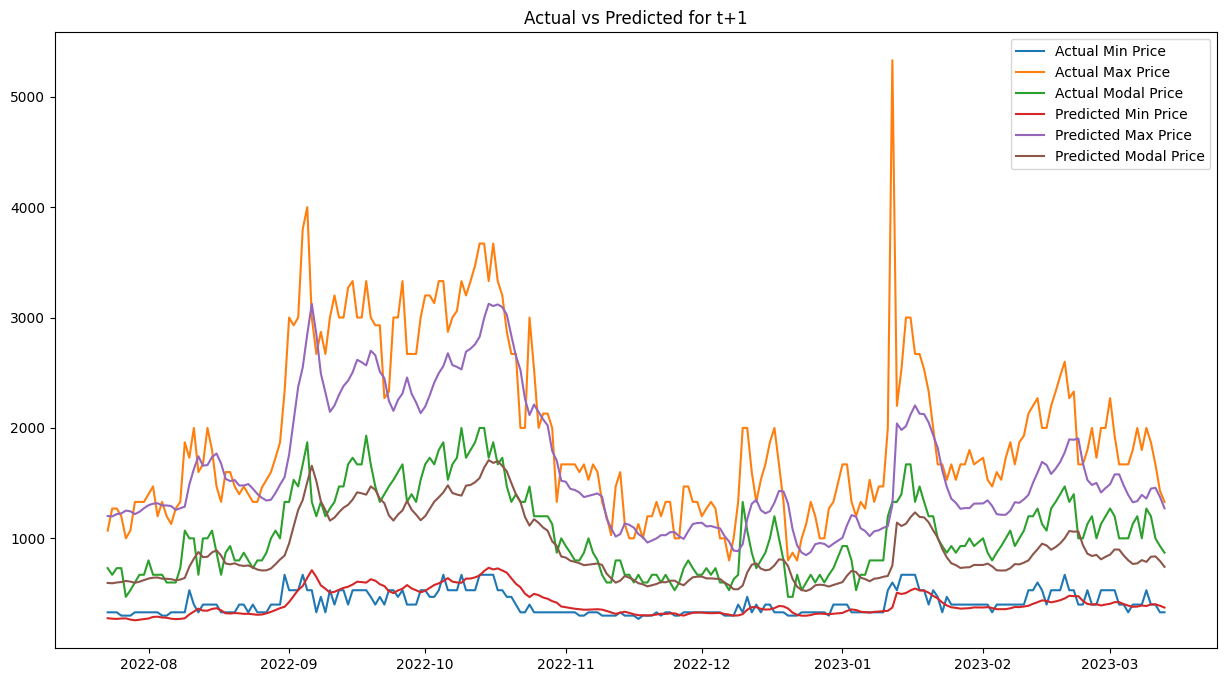

In [59]:
plt.plot(pred_df['act_min_t1'],  label='Actual Min Price')
plt.plot(pred_df['act_max_t1'],  label='Actual Max Price')
plt.plot(pred_df['act_mode_t1'], label='Actual Modal Price')
plt.plot(pred_df['pred_min_t1'],  label='Predicted Min Price')
plt.plot(pred_df['pred_max_t1'],  label='Predicted Max Price')
plt.plot(pred_df['pred_mode_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 2 - Encoder - Decoder model using Bi LSTM

## Model building

In [60]:
# Build the Encoder - Decoder using Bi-LSTM model
model_encDec_2 = Sequential()
model_encDec_2.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True), 
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_encDec_2.add(LSTM(32, activation='relu', return_sequences=False))
model_encDec_2.add(RepeatVector(vec_train_y.shape[1]))
model_encDec_2.add(LSTM(32, activation='relu', return_sequences=True))
model_encDec_2.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True), 
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_encDec_2.add(TimeDistributed(Dense(vec_train_X.shape[2])))
#model_encDec_2.build(input_shape=(vec_train_X.shape[1], vec_train_X.shape[2]))
model_encDec_2.compile(optimizer='adam', loss='mae')
model_encDec_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           35328     
 l)                                                              
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 32)            0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 5, 32)             8320      
                                                                 
 bidirectional_1 (Bidirectio  (None, 5, 128)           49664     
 nal)                                                            
                                                      

In [61]:
# fit network
history_2 = model_encDec_2.fit(vec_train_X, vec_train_y, epochs=50, batch_size=100, 
                             validation_data=(vec_test_X, vec_test_y), verbose=2,
                             shuffle=False)

Epoch 1/50
10/10 - 12s - loss: 0.1831 - val_loss: 0.1195 - 12s/epoch - 1s/step
Epoch 2/50
10/10 - 0s - loss: 0.1385 - val_loss: 0.0766 - 372ms/epoch - 37ms/step
Epoch 3/50
10/10 - 0s - loss: 0.1180 - val_loss: 0.0710 - 389ms/epoch - 39ms/step
Epoch 4/50
10/10 - 0s - loss: 0.1106 - val_loss: 0.0670 - 391ms/epoch - 39ms/step
Epoch 5/50
10/10 - 0s - loss: 0.1050 - val_loss: 0.0651 - 379ms/epoch - 38ms/step
Epoch 6/50
10/10 - 0s - loss: 0.1004 - val_loss: 0.0632 - 397ms/epoch - 40ms/step
Epoch 7/50
10/10 - 0s - loss: 0.0967 - val_loss: 0.0626 - 380ms/epoch - 38ms/step
Epoch 8/50
10/10 - 0s - loss: 0.0944 - val_loss: 0.0610 - 380ms/epoch - 38ms/step
Epoch 9/50
10/10 - 0s - loss: 0.0914 - val_loss: 0.0608 - 391ms/epoch - 39ms/step
Epoch 10/50
10/10 - 0s - loss: 0.0878 - val_loss: 0.0594 - 385ms/epoch - 39ms/step
Epoch 11/50
10/10 - 0s - loss: 0.0856 - val_loss: 0.0588 - 397ms/epoch - 40ms/step
Epoch 12/50
10/10 - 0s - loss: 0.0805 - val_loss: 0.0589 - 379ms/epoch - 38ms/step
Epoch 13/50
10/1

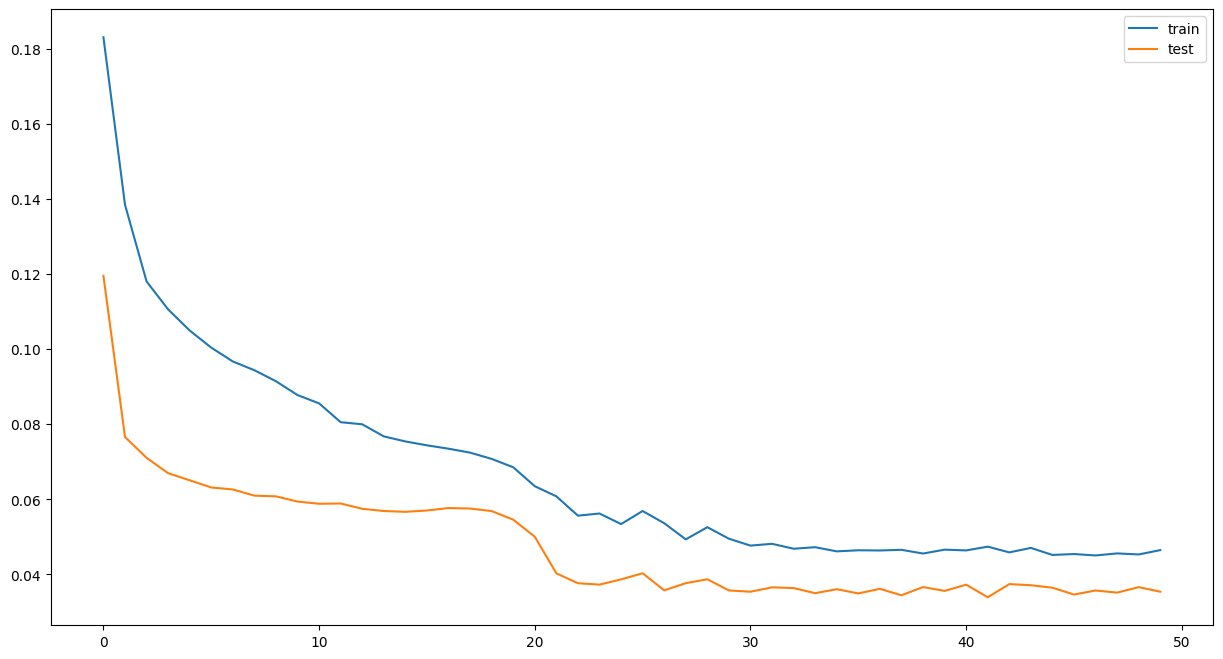

In [62]:
# plot history
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [63]:
# make a prediction
pred2_y = model_encDec_2.predict(vec_test_X)

8/8 [==============================] - 1s 7ms/step


In [64]:
pred2_y[:5]

array([[[0.8829273 , 0.06831122, 0.09476319, 0.07974678],
        [0.8998127 , 0.06338743, 0.089128  , 0.07246424],
        [0.90515536, 0.06197673, 0.08962631, 0.07003378],
        [0.9047799 , 0.06323178, 0.0921452 , 0.07314352],
        [0.9011737 , 0.06633716, 0.09361109, 0.08222178]],

       [[0.8709258 , 0.06612123, 0.09211074, 0.07734311],
        [0.8878594 , 0.0611967 , 0.0865248 , 0.06999844],
        [0.89312875, 0.05984264, 0.08715951, 0.06756486],
        [0.8924652 , 0.06117649, 0.0899299 , 0.0707073 ],
        [0.88843185, 0.06437811, 0.0918078 , 0.07976691]],

       [[0.8509177 , 0.06418075, 0.09069765, 0.07562014],
        [0.86797404, 0.05937421, 0.08527991, 0.06835943],
        [0.8732321 , 0.05809638, 0.08591357, 0.0659385 ],
        [0.8722346 , 0.05950655, 0.08868881, 0.06898946],
        [0.8674403 , 0.06280155, 0.09075279, 0.07784478]],

       [[0.8574089 , 0.0640424 , 0.09077646, 0.07577217],
        [0.8743906 , 0.0591324 , 0.08531839, 0.06846917],
        

In [65]:
pred2_y.shape

(232, 5, 4)

## Resacling Prediction

In [66]:
data_pred2 = test_data.copy()

In [67]:
for i in data_pred2.columns:
  if i.startswith('target'):
    data_pred2.drop(columns=i,inplace=True)

In [68]:
# Creating Testing dataset
temp_pred2_df = pd.DataFrame(data=pred2_y.reshape(test_data.shape[0],20),
                            index=test_data.index,
                            columns=['pred_qty_t1',	'pred_min_t1',	'pred_max_t1',	'pred_mode_t1',
                                      'pred_qty_t2',	'pred_min_t2',	'pred_max_t2',	'pred_mode_t2',
                                      'pred_qty_t3',	'pred_min_t3',	'pred_max_t3',	'pred_mode_t3',
                                      'pred_qty_t4',	'pred_min_t4',	'pred_max_t4',	'pred_mode_t4',
                                      'pred_qty_t5',	'pred_min_t5',	'pred_max_t5',	'pred_mode_t5'])

In [69]:
data_pred2 = data_pred2.join(temp_pred2_df)
data_pred2

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,...,pred_max_t3,pred_mode_t3,pred_qty_t4,pred_min_t4,pred_max_t4,pred_mode_t4,pred_qty_t5,pred_min_t5,pred_max_t5,pred_mode_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.875826,0.0825,0.115340,0.111667,0.841792,0.1175,...,0.089626,0.070034,0.904780,0.063232,0.092145,0.073144,0.901174,0.066337,0.093611,0.082222
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.878514,0.0825,0.115340,0.111667,0.875826,0.0825,...,0.087160,0.067565,0.892465,0.061176,0.089930,0.070707,0.888432,0.064378,0.091808,0.079767
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.867811,0.0825,0.123414,0.121667,0.878514,0.0825,...,0.085914,0.065939,0.872235,0.059507,0.088689,0.068989,0.867440,0.062802,0.090753,0.077845
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.809613,0.0825,0.146482,0.111667,0.867811,0.0825,...,0.086019,0.066052,0.878643,0.059280,0.088913,0.069170,0.874083,0.062662,0.091047,0.078116
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.857989,0.0825,0.146482,0.121667,0.809613,0.0825,...,0.087281,0.066707,0.860351,0.059603,0.089782,0.069613,0.855057,0.062925,0.091611,0.078228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.081435,0.1000,0.230681,0.200000,0.088593,0.1000,...,0.169855,0.136422,0.085683,0.091454,0.165633,0.134135,0.090667,0.088033,0.156513,0.130358
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.068354,0.1000,0.207612,0.166667,0.081435,0.1000,...,0.183323,0.145868,0.086467,0.095352,0.178982,0.143424,0.091470,0.092286,0.169221,0.139329
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.083385,0.1325,0.230681,0.211667,0.068354,0.1000,...,0.186359,0.148368,0.085771,0.096956,0.181972,0.145892,0.090855,0.094026,0.172048,0.141725


In [70]:
inv_pred2_y = scaler.inverse_transform(data_pred2)
inv_pred2_y = inv_pred2_y[:,-20:]

In [71]:
# Display Predicted values
inv_pred2_y[:2,]

array([[37242.15584123,   333.80465817,  1183.69157761,   662.53129691,
        37935.01445198,   314.42954179,  1137.08858088,   620.29256374,
        38154.23991555,   308.87845045,  1141.20960236,   606.19593114,
        38138.83408976,   313.81705873,  1162.04084158,   624.23241287,
        37990.8608762 ,   326.03672761,  1174.16372567,   676.88634545],
       [36749.69769943,   325.18703233,  1161.75580457,   648.59005958,
        37444.5349279 ,   305.80899881,  1115.56009158,   605.99092692,
        37660.75210989,   300.48078317,  1120.80918431,   591.87618792,
        37633.52349287,   305.72947364,  1143.72028179,   610.10233313,
        37468.02398187,   318.32784358,  1159.25048575,   662.64810264]])

## Comapring Actuals vs Predicted

In [72]:
pred2_df = pd.DataFrame(index=test_data.index)

In [73]:
k = 1
for i in range(0,20,4):
  pred2_df['act_qty_t'+str(k)] = inv_test_y[:,i]
  pred2_df['pred_qty_t'+str(k)] = inv_pred2_y[:,i]
  i = i+1
  pred2_df['act_min_t'+str(k)] = inv_test_y[:,i]
  pred2_df['pred_min_t'+str(k)] = inv_pred2_y[:,i]
  i = i+1
  pred2_df['act_max_t'+str(k)] = inv_test_y[:,i]
  pred2_df['pred_max_t'+str(k)] = inv_pred2_y[:,i]
  i = i+1
  pred2_df['act_mode_t'+str(k)] = inv_test_y[:,i]
  pred2_df['pred_mode_t'+str(k)] = inv_pred2_y[:,i]
  k=k+1


In [74]:
pred2_df

,act_qty_t1,pred_qty_t1,act_min_t1,pred_min_t1,act_max_t1,pred_max_t1,act_mode_t1,pred_mode_t1,act_qty_t2,pred_qty_t2,...,act_mode_t4,pred_mode_t4,act_qty_t5,pred_qty_t5,act_min_t5,pred_min_t5,act_max_t5,pred_max_t5,act_mode_t5,pred_mode_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,36488.0,37242.155841,330.0,333.804658,1070.0,1183.691578,730.0,662.531297,34041.0,37935.014452,...,730.0,624.232413,31025.0,37990.860876,300.0,326.036728,1000.0,1174.163726,470.0,676.886345
2022-07-24,34041.0,36749.697699,330.0,325.187032,1270.0,1161.755805,670.0,648.590060,36075.0,37444.534928,...,470.0,610.102333,26480.0,37468.023982,300.0,318.327844,1070.0,1159.250486,530.0,662.648103
2022-07-25,36075.0,35928.705859,330.0,317.551267,1270.0,1150.069534,730.0,638.596839,33781.0,36628.578902,...,530.0,600.138843,31449.0,36606.677145,330.0,312.124118,1330.0,1150.525556,600.0,651.499745
2022-07-26,33781.0,36195.058622,300.0,317.006861,1200.0,1150.721311,730.0,639.478607,31025.0,36891.869576,...,600.0,601.183181,31102.0,36879.239685,330.0,311.573789,1330.0,1152.954779,670.0,653.072755
2022-07-27,31025.0,35440.703887,300.0,317.087515,1000.0,1160.618552,470.0,641.676785,26480.0,36144.421661,...,670.0,603.755154,30060.0,36098.568601,330.0,312.608481,1330.0,1157.620796,670.0,653.724715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,3506.0,4704.218984,530.0,424.419432,2000.0,1734.585431,1270.0,969.273478,3698.0,4536.773873,...,930.0,977.982873,4464.0,4733.338783,330.0,411.410786,1330.0,1694.366376,870.0,956.074128
2023-03-10,3698.0,4748.655033,400.0,440.966942,1870.0,1840.482287,1200.0,1021.521464,2950.0,4570.508205,...,870.0,1031.858620,3434.0,4766.297199,330.0,428.146106,1330.0,1799.459140,930.0,1008.106565
2023-03-11,2950.0,4725.310890,400.0,446.515262,1670.0,1865.045133,1000.0,1035.222262,3678.0,4541.773613,...,930.0,1046.170974,3961.0,4741.032830,330.0,434.990929,1200.0,1822.840308,730.0,1022.007874


In [75]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [76]:
# Calculate the error
error2 = pd.Series()
k=1
for i in range(0,20,4):
  error2['MAPE_qty_'+str(k)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred2_y[:,i]).numpy()
  i = i+1
  error2['MAPE_min_'+str(k)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred2_y[:,i]).numpy()
  i = i+1
  error2['MAPE_max_'+str(k)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred2_y[:,i]).numpy()
  i = i+1
  error2['MAPE_mode_'+str(k)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred2_y[:,i]).numpy()
  k = k+1
print("Results of sklearn.metrics:")
print(error2)

Results of sklearn.metrics:
MAPE_qty_1     28.166850
MAPE_min_1     15.006056
MAPE_max_1     14.510087
MAPE_mode_1    13.302223
MAPE_qty_2     30.849886
MAPE_min_2     17.207749
MAPE_max_2     16.988057
MAPE_mode_2    15.765645
MAPE_qty_3     31.753508
MAPE_min_3     18.433455
MAPE_max_3     18.602591
MAPE_mode_3    17.225879
MAPE_qty_4     32.926555
MAPE_min_4     19.002237
MAPE_max_4     19.992785
MAPE_mode_4    18.181410
MAPE_qty_5     34.347752
MAPE_min_5     19.698369
MAPE_max_5     20.897023
MAPE_mode_5    18.964663
dtype: float64


In [77]:
model_comparision['Seq2Seq_BiDir_LSTM_2'] = error2
model_comparision

,Seq2Seq_LSTM,Seq2Seq_BiDir_LSTM_2
MAPE_qty_1,24.572348,28.166850
MAPE_min_1,14.811780,15.006056
MAPE_max_1,17.664582,14.510087
MAPE_mode_1,16.393050,13.302223
MAPE_qty_2,25.820694,30.849886
MAPE_min_2,18.290123,17.207749
MAPE_max_2,16.027978,16.988057
MAPE_mode_2,15.085934,15.765645
MAPE_qty_3,27.213975,31.753508
MAPE_min_3,18.721792,18.433455


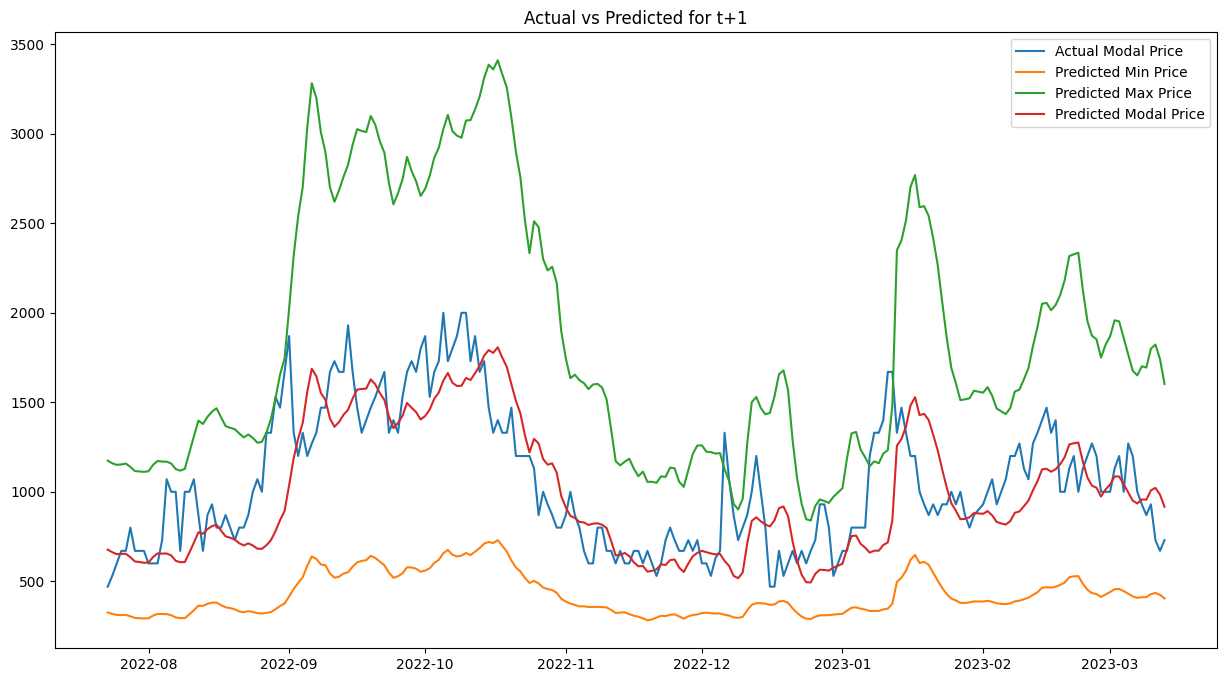

In [78]:
plt.plot(pred2_df['act_mode_t5'], label='Actual Modal Price')
plt.plot(pred2_df['pred_min_t5'],  label='Predicted Min Price')
plt.plot(pred2_df['pred_max_t5'],  label='Predicted Max Price')
plt.plot(pred2_df['pred_mode_t5'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# TO DO FROM HERE

# Model 3 - Seq to Seq CNN LSTM

## Model building

In [ ]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir2 = Sequential()
model_Stacked_biDir2.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir2.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir2.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir2.compile(optimizer='adam', loss='mae')

In [ ]:
model_Stacked_biDir2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 30, 100)          22000     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 82,905
Trainable params: 82,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit network
history_2 = model_Stacked_biDir2.fit(vec_train_X, vec_train_y, epochs=300, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/300
10/10 - 8s - loss: 0.1435 - val_loss: 0.0844 - 8s/epoch - 797ms/step
Epoch 2/300
10/10 - 2s - loss: 0.0975 - val_loss: 0.0524 - 2s/epoch - 155ms/step
Epoch 3/300
10/10 - 3s - loss: 0.0752 - val_loss: 0.0438 - 3s/epoch - 345ms/step
Epoch 4/300
10/10 - 2s - loss: 0.0649 - val_loss: 0.0478 - 2s/epoch - 211ms/step
Epoch 5/300
10/10 - 2s - loss: 0.0630 - val_loss: 0.0447 - 2s/epoch - 192ms/step
Epoch 6/300
10/10 - 1s - loss: 0.0608 - val_loss: 0.0417 - 962ms/epoch - 96ms/step
Epoch 7/300
10/10 - 1s - loss: 0.0557 - val_loss: 0.0425 - 998ms/epoch - 100ms/step
Epoch 8/300
10/10 - 1s - loss: 0.0533 - val_loss: 0.0392 - 978ms/epoch - 98ms/step
Epoch 9/300
10/10 - 2s - loss: 0.0481 - val_loss: 0.0400 - 2s/epoch - 211ms/step
Epoch 10/300
10/10 - 3s - loss: 0.0467 - val_loss: 0.0385 - 3s/epoch - 279ms/step
Epoch 11/300
10/10 - 4s - loss: 0.0441 - val_loss: 0.0374 - 4s/epoch - 378ms/step
Epoch 12/300
10/10 - 3s - loss: 0.0424 - val_loss: 0.0371 - 3s/epoch - 267ms/step
Epoch 13/300
10/10

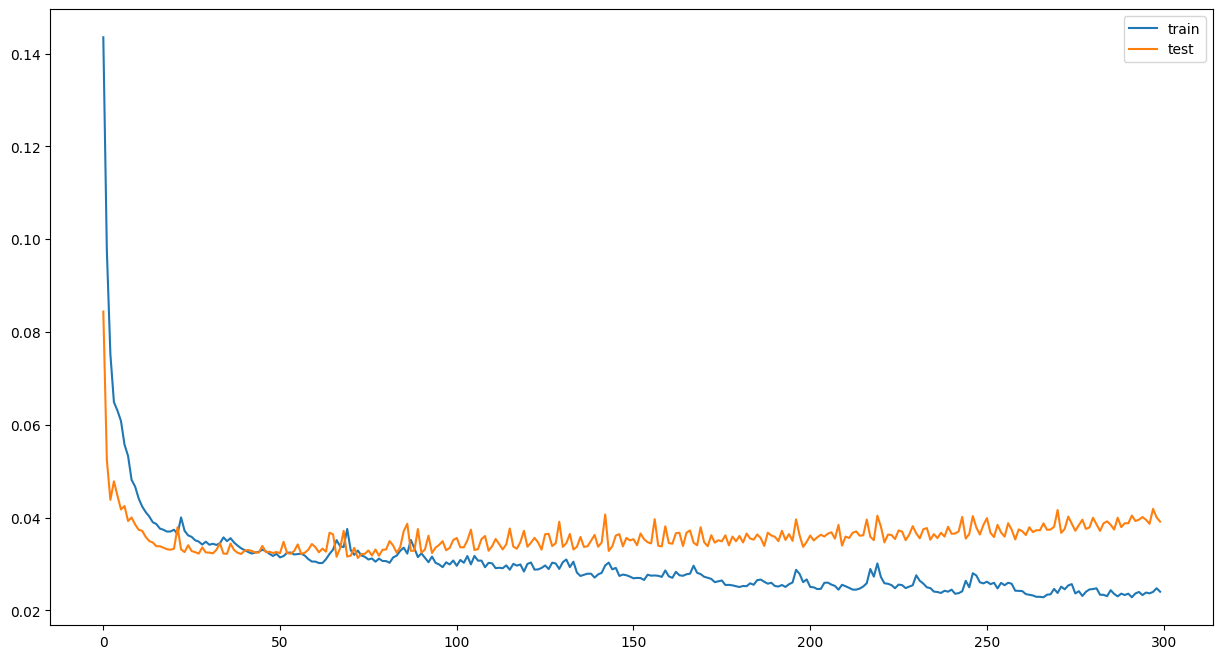

In [ ]:
# plot history
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [ ]:
# make a prediction
pred2_y = model_Stacked_biDir2.predict(vec_test_X)

8/8 [==============================] - 1s 12ms/step


In [ ]:
pred2_y[:5]

array([[0.05376344, 0.06591735, 0.07677159, 0.08029627, 0.09315828],
       [0.05423459, 0.06535766, 0.07461557, 0.08044276, 0.09193955],
       [0.05476264, 0.06621761, 0.07432655, 0.08179992, 0.09320313],
       [0.05468137, 0.06580295, 0.07314569, 0.08125599, 0.09106816],
       [0.0542101 , 0.06468799, 0.07172454, 0.08142409, 0.08904838]],
      dtype=float32)

In [ ]:
pred2_y.shape

(226, 5)

## Resacling Prediction

In [ ]:
data2_pred = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [ ]:
for i in range(0,5):
  data2_pred['prediction_t'+str(i+1)] = pred2_y[:,i]

In [ ]:
data2_pred

,quantity_t1,min_price_t1,max_price_t1,modal_price_t1,quantity_t2,min_price_t2,max_price_t2,modal_price_t2,quantity_t3,min_price_t3,...,modal_price_t29,quantity_t30,min_price_t30,max_price_t30,modal_price_t30,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-06-30,0.783564,0.067344,0.112455,0.115517,0.791753,0.085133,0.112455,0.091379,0.753199,0.118170,...,0.046552,0.620647,0.059720,0.081016,0.056897,0.053763,0.065917,0.076772,0.080296,0.093158
2022-07-01,0.791753,0.085133,0.112455,0.091379,0.753199,0.118170,0.153567,0.137931,0.773524,0.118170,...,0.056897,0.741744,0.067344,0.112455,0.068966,0.054235,0.065358,0.074616,0.080443,0.091940
2022-07-02,0.753199,0.118170,0.153567,0.137931,0.773524,0.118170,0.177751,0.150000,0.763386,0.153748,...,0.068966,0.733288,0.067344,0.112455,0.081034,0.054763,0.066218,0.074327,0.081800,0.093203
2022-07-03,0.773524,0.118170,0.177751,0.150000,0.763386,0.153748,0.233374,0.194828,0.863866,0.153748,...,0.081034,0.707894,0.067344,0.112455,0.081034,0.054681,0.065803,0.073146,0.081256,0.091068
2022-07-04,0.763386,0.153748,0.233374,0.194828,0.863866,0.153748,0.233374,0.194828,0.844345,0.085133,...,0.081034,0.963663,0.067344,0.120919,0.103448,0.054210,0.064688,0.071725,0.081424,0.089048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-08,0.089928,0.085133,0.177751,0.150000,0.100407,0.085133,0.153567,0.125862,0.083031,0.085133,...,0.172414,0.045354,0.085133,0.169287,0.137931,0.117142,0.109111,0.111087,0.104723,0.103711
2023-02-09,0.100407,0.085133,0.153567,0.125862,0.083031,0.085133,0.177751,0.137931,0.084249,0.085133,...,0.137931,0.060756,0.118170,0.193470,0.184483,0.127256,0.115470,0.116255,0.110590,0.109095
2023-02-10,0.083031,0.085133,0.177751,0.137931,0.084249,0.085133,0.185006,0.150000,0.094022,0.118170,...,0.184483,0.065435,0.085133,0.177751,0.172414,0.125454,0.113447,0.114490,0.108156,0.106917


In [ ]:
inv_pred2_y = scaler.inverse_transform(data2_pred)
inv_pred2_y = inv_pred2_y[:,-5:]

In [ ]:
# Display Predicted values
inv_pred2_y[:5,]

array([[511.8279621 , 582.32063204, 645.27524859, 665.71836919,
        740.31803757],
       [514.56060261, 579.07440066, 632.77029395, 666.5679872 ,
        733.24941099],
       [517.62330681, 584.06213075, 631.09400421, 674.43956137,
        740.57818204],
       [517.15195701, 581.657134  , 624.24498796, 671.28472626,
        728.19534838],
       [514.41860348, 575.19033998, 616.00234061, 672.25970626,
        716.48059338]])

## Comapring Actuals vs Predicted

In [ ]:
pred2_df = test_data[['quantity_t1']]

In [ ]:
for i in range(0,5):
  pred2_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred2_df['prediction_t'+str(i+1)] = inv_pred2_y[:,i]

In [ ]:
pred2_df

,quantity_t1,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-06-30,0.783564,600.0,511.827962,670.0,582.320632,670.0,645.275249,800.0,665.718369,670.0,740.318038
2022-07-01,0.791753,670.0,514.560603,670.0,579.074401,800.0,632.770294,670.0,666.567987,670.0,733.249411
2022-07-02,0.753199,670.0,517.623307,800.0,584.062131,670.0,631.094004,670.0,674.439561,670.0,740.578182
2022-07-03,0.773524,800.0,517.151957,670.0,581.657134,670.0,624.244988,670.0,671.284726,600.0,728.195348
2022-07-04,0.763386,670.0,514.418603,670.0,575.190340,670.0,616.002341,600.0,672.259706,600.0,716.480593
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-08,0.089928,1270.0,879.423380,1200.0,832.846630,1000.0,844.304827,930.0,807.393438,870.0,801.523679
2023-02-09,0.100407,1200.0,938.086563,1000.0,869.725738,930.0,874.279563,870.0,841.423187,930.0,832.753159
2023-02-10,0.083031,1000.0,927.635843,930.0,857.993180,870.0,864.044347,930.0,827.305552,730.0,820.116965


In [ ]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [ ]:
# Calculate the error
error2 = pd.Series()
for i in range(0,5):
  error2['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred2_y[:,i])
print("Results of sklearn.metrics:")
print(error2)

Results of sklearn.metrics:
MAPE_1    0.170720
MAPE_2    0.201697
MAPE_3    0.217726
MAPE_4    0.233702
MAPE_5    0.249646
dtype: float64


In [ ]:
model_comparision['Stacked_BiDir_LSTM_2'] = error2
model_comparision

,LSTM,Stacked_BiDir_LSTM_2
MAPE_1,0.148954,0.170720
MAPE_2,0.175026,0.201697
MAPE_3,0.187679,0.217726
MAPE_4,0.193591,0.233702
MAPE_5,0.202638,0.249646


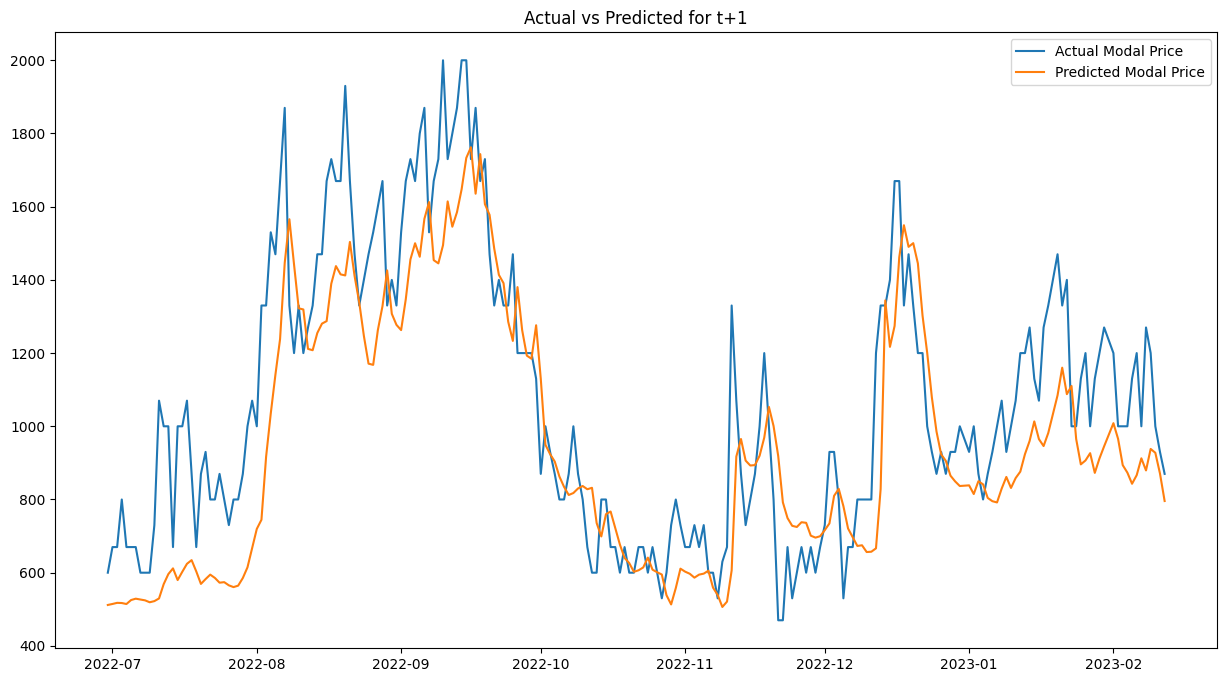

In [ ]:
plt.plot(pred2_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred2_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()